In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

In [2]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 8.2 MB/s 
     |████████████████████████████████| 6.3 MB 35.9 MB/s 
     |████████████████████████████████| 15.4 MB 4.4 MB/s 


In [2]:
#to convert a geographic point into a circular buffer with radius in meters.

from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj

# def buffer_in_meters(lng, lat, radius):
def buffer_in_meters(pt_latlng, radius):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
#     pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    
    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [3]:
gdf_county = gpd.read_file("county.zip")

<AxesSubplot:>

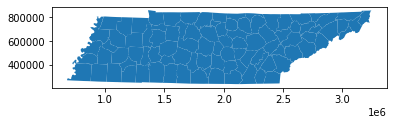

In [4]:
gdf_county.plot()

In [5]:
gdf_dav = gdf_county[gdf_county["COUNTY"] == "Davidson"]

In [6]:
gdf_dav.head()

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry
30,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1725320.674 734952.517, 1725410.826 ..."
49,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((1814456.873 657102.349, 1813945.726 ..."


In [7]:
gdf_david = gdf_dav.to_crs("EPSG:4326")
gdf_david.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds

array([1656664.95403244,  595562.71399883, 1816136.87059501,
        755249.86127501])

In [9]:
length = 5280
wide = 5280

cols = list(np.arange(xmin, xmax + wide, wide))
print(len(cols))
rows = list(np.arange(ymin, ymax + length, length))
print(len(cols))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.to_file("grid.shp")
# grid.plot()

32
32


<AxesSubplot:>

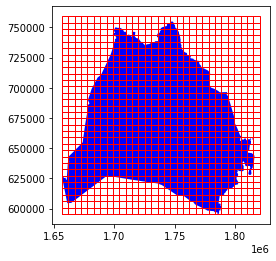

In [10]:
grid.plot(ax = gdf_dav.plot(color='blue'), color='none', edgecolor='red')

In [11]:
df_incidents = pd.read_json("incident.json")
gdf_incidents2 = gpd.GeoDataFrame(
    df_incidents, geometry=gpd.points_from_xy(df_incidents.longitude, df_incidents.latitude))
incidents = gdf_incidents2.set_crs("EPSG:4326")
incidents.head()

,ID_Original,latitude,longitude,emdCardNumber,time_utc,fireZone,time,time_local,response_time_sec,year,month,day,day_of_week,weekend_or_not,hour,window,geometry,Incident_ID,Dist_to_Seg,XDSegID
0,ObjectId(59d3a81908f47311c891f8e2),36.037228,-86.783243,29B5,1483257569507,10,1483257569507,1483235969507,268.0,2017,1,1,6,1,1,23,POINT (-86.78324 36.03723),10,13.550370,1.524394e+09
1,ObjectId(59d3a81908f47311c891f8e6),36.037414,-86.786572,29D2P,1483259455000,10,1483259455000,1483237855000,512.0,2017,1,1,6,1,2,30,POINT (-86.78657 36.03741),11,3.663952,1.524356e+09
2,ObjectId(59d3a81a08f47311c891f8ef),36.217663,-86.808699,29D1H,1483263310000,25,1483263310000,1483241710000,271.0,2017,1,1,6,1,3,43,POINT (-86.80870 36.21766),12,NaN,NaN
3,ObjectId(59d3a81a08f47311c891f8f9),36.057790,-86.739728,29D8V,1483266571867,10,1483266571867,1483244971867,366.0,2017,1,1,6,1,4,53,POINT (-86.73973 36.05779),13,NaN,NaN
4,ObjectId(59d3a81a08f47311c891f904),36.039221,-86.602785,29A2V,1483268953000,33,1483268953000,1483247353000,447.0,2017,1,1,6,1,5,61,POINT (-86.60279 36.03922),14,3.171782,4.496208e+08


In [ ]:
# dav_grids = gpd.overlay(gdf_dav, grid, how='intersection')
# dav_grids.plot()

In [12]:
grids = grid.set_crs("EPSG:2274")
grids.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Tennessee - counties of Anderson; Bedford; Benton; Bledsoe; Blount; Bradley; Campbell; Cannon; Carroll; Carter; Cheatham; Chester; Claiborne; Clay; Cocke; Coffee; Crockett; Cumberland; Davidson; De Kalb; Decatur; Dickson; Dyer; Fayette; Fentress; Franklin; Gibson; Giles; Grainger; Greene; Grundy; Hamblen; Hamilton; Hancock; Hardeman; Hardin; Hawkins; Haywood; Henderson; Henry; Hickman; Houston; Humphreys; Jackson; Jefferson; Johnson; Knox; Lake; Lauderdale; Lawrence; Lewis; Lincoln; Loudon; Macon; Madison; Marion; Marshall; Maury; McMinn; McNairy; Meigs; Monroe; Montgomery; Moore; Morgan; Obion; Overton; Perry; Pickett; Polk; Putnam; Rhea; Roane; Robertson; Rutherford; Scott; Sequatchie; Sevier; Shelby; Smith; Stewart; Sullivan; Sumner; Tipton; Trousdale; Unicoi; Union; Van Buren; Warren; Wa

In [13]:
dav_grids = gpd.overlay(gdf_dav, grids, how='intersection')
# dav_grids.plot(figsize=(10, 10))
# plt.show()
# dav_grids.shape

In [14]:
dav_grids['grid_num'] = np.arange(len(dav_grids))

In [15]:
dav_grids2 = dav_grids.to_crs("EPSG:4326")

In [16]:
dav_grids2

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry,grid_num
0,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.03922 35.98939, -87.04042 35.993...",0
1,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04103 35.99633, -87.04244 36.001...",1
2,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04592 36.01500, -87.04780 36.022...",2
3,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.04958 36.02909, -87.05145 36.036...",3
4,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-87.05207 36.03851, -87.05333 36.043...",4
...,...,...,...,...,...,...,...,...,...
599,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.53578 36.13838, -86.53350 36.137...",599
600,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((-86.52341 36.13752, -86.52274 36.140...",600
601,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.51764 36.08397, -86.51927 36.084...",601
602,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((-86.51678 36.09155, -86.51759 36.084...",602


In [17]:
joined2 = incidents.sjoin(dav_grids2, how="right")
# joined2[joined2["grid_num"]==299]

In [18]:
joined2.grid_num.value_counts()

299    569
325    559
382    544
479    534
274    515
      ... 
240      1
241      1
242      1
258      1
603      1
Name: grid_num, Length: 604, dtype: int64

In [19]:
inc_grids = pd.Series.tolist(joined2.grid_num.value_counts())


In [20]:
inc_index = list(joined2.grid_num.value_counts().index)

In [ ]:
# inc_index.sort()

In [ ]:
# dax = dav_grids2.plot(figsize=(20, 20))
# joined2[joined2.row_num == 299].plot(ax = dax, figsize=(20, 20), color='red')

In [ ]:
# dav_grids2["no_of_incidents"] = 0
# dav_grids2.head()

In [21]:
dav_grids2["no_of_incidents"] = 0

for i in range(len(inc_index)):
#     print("i",i)
    for j in range(dav_grids2.shape[0]):
#         print(j, joined["row_num"][j], inc_index[i], inc_grids[i])
        if (dav_grids2["grid_num"][j] == inc_index[i]):
            dav_grids2["no_of_incidents"][j]= inc_grids[i]
        
        

C:\Users\risha\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

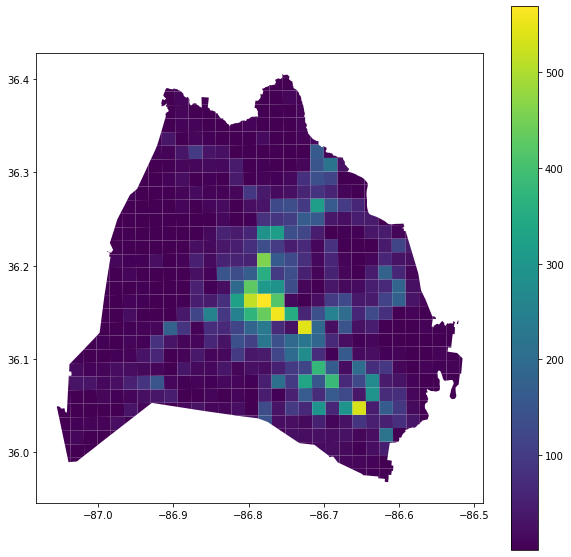

In [22]:
dav_grids2.plot(column='no_of_incidents', legend=True, figsize=(10, 10))

In [23]:
import math
start_time = 1483250400000 # 2017-01-01 00:00:00
# start_time = g_dav.time_local.min()
end_time = 1614671157253 # 2021-03-02 01:45:57.253000
# end_time = g_dav.time_local.max()

curr_time = start_time/1000
# print(start_time/1000)

incidents_per_month = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/2592000))]
incidents_per_day = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/86400))]
incidents_per_4hrs = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/14400)+10)]
print(int(math.ceil((end_time - start_time)/1000)/14400))

9126


In [ ]:
counter_4hrs = 0

for i in range(0, g_dav.shape[0]):
    inc_time = (g_dav.time_local.iloc[i])/1000 #incident time #incidents.time_local
    while True:
        limit_time = curr_time +14400
#         print(inc_time-limit_time, inc_time-curr_time)
        if (inc_time < limit_time):
            incidents_per_4hrs[counter_4hrs]+=1
            break
    
        else:
            curr_time = limit_time
            counter_4hrs += 1
        
# print(counter_4hrs)
# print(incidents_per_4hrs)
sum(incidents_per_4hrs)

 

NameError: name 'g_dav' is not defined

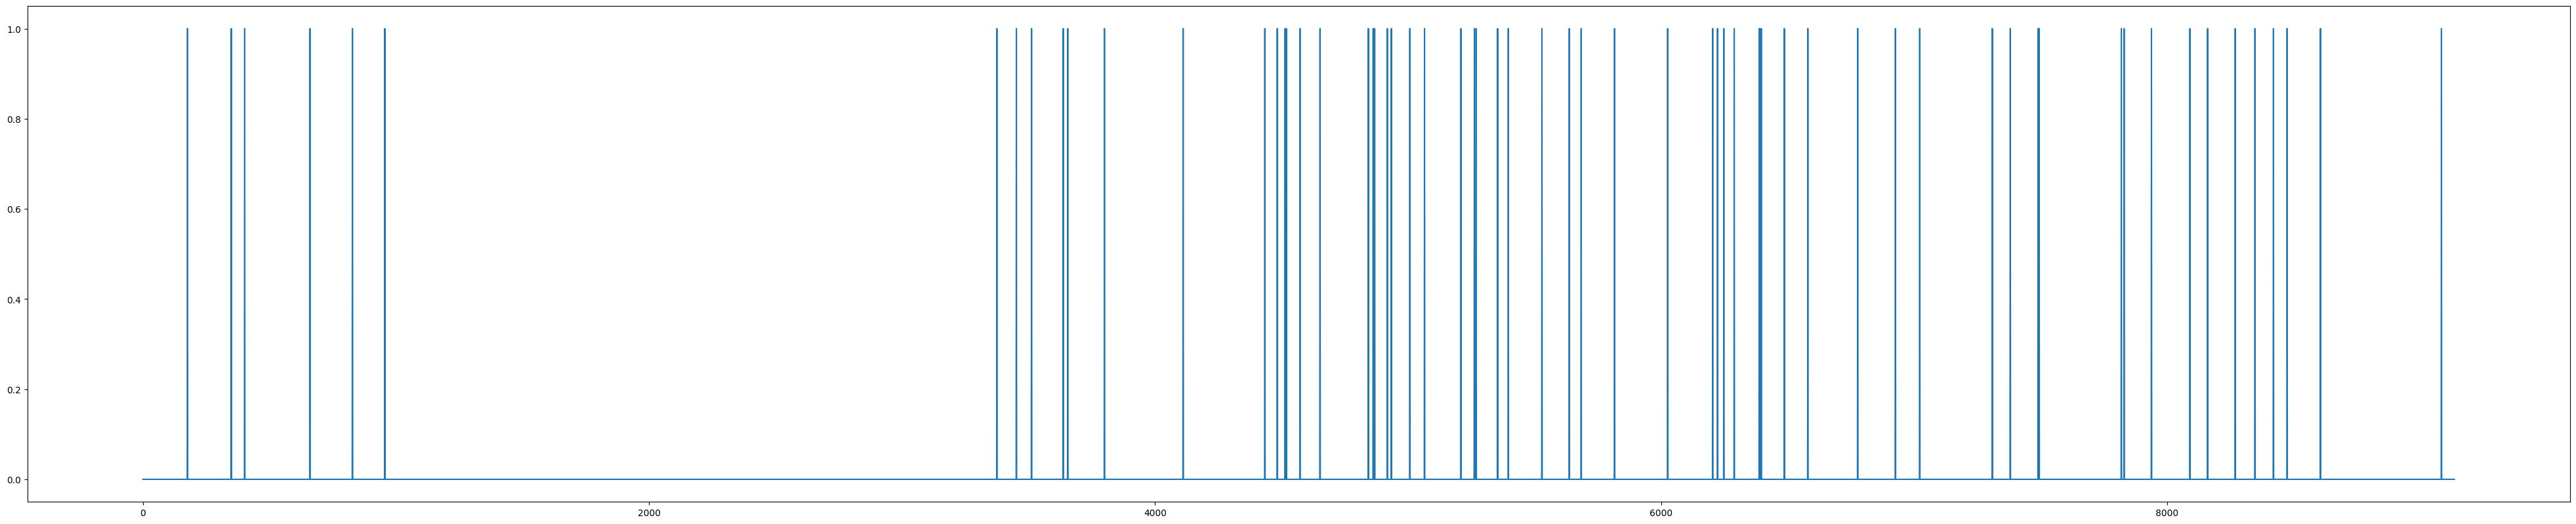

In [ ]:
plt.figure(figsize=(50, 10), dpi=100)
plt.plot(incidents_per_4hrs)

In [ ]:
sum_day = incidents_per_4hrs[0]
counter_day = 0
for i in range(1, counter_4hrs+1): 
    if i%6 == 0:
        incidents_per_day[counter_day] = sum_day
        counter_day+=1
        sum_day = 0
    sum_day += incidents_per_4hrs[i]
    
# print(incidents_per_day)

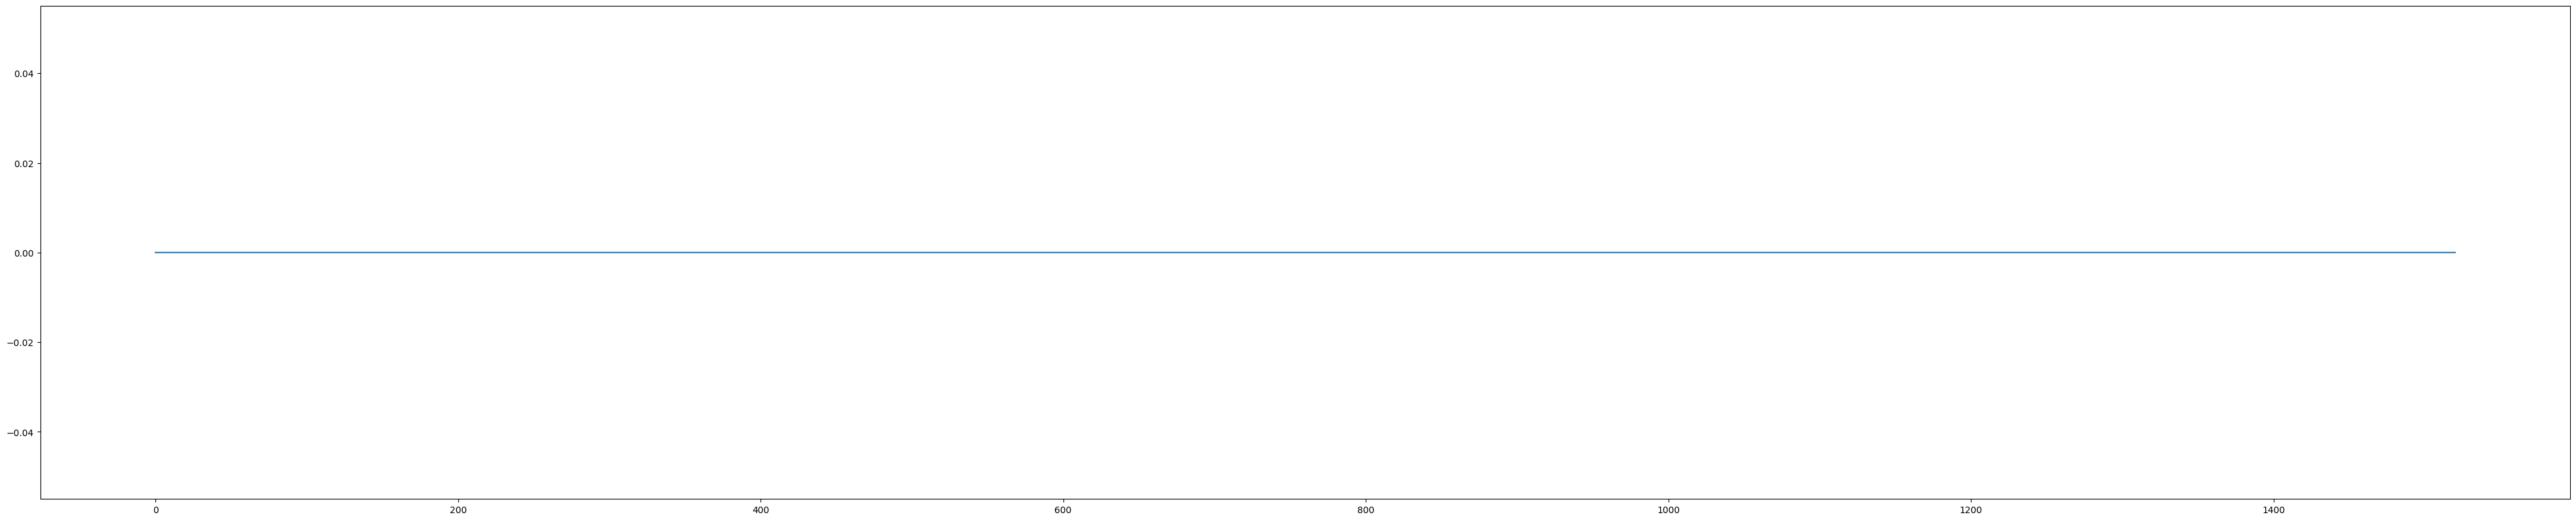

In [ ]:
plt.figure(figsize=(50, 10), dpi=100)
plt.plot(incidents_per_day)

In [ ]:
sum_month = incidents_per_day[0]
counter_month = 0
for i in range(1, counter_day): 
    if i%30 == 0:
        incidents_per_month[counter_month] = sum_month
        counter_month+=1
        sum_month = 0
    sum_month += incidents_per_day[i]
# print(incidents_per_month)

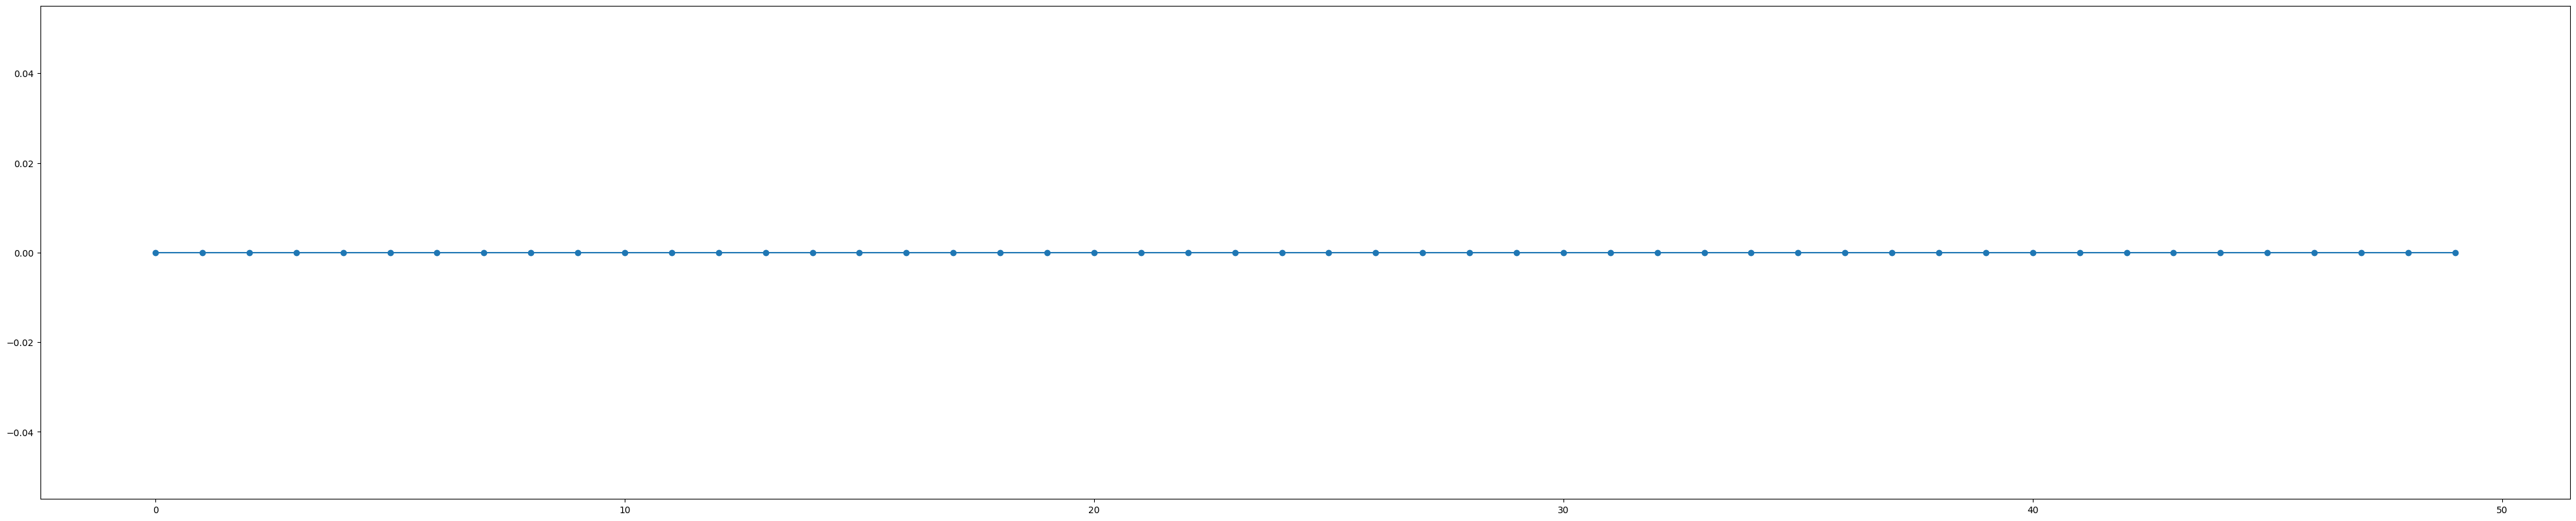

In [ ]:
values = pd.date_range('2017-01-01','2021-02-01', freq='MS').strftime("%Y-%m").tolist()
# print(values)
plt.figure(figsize=(50, 10), dpi=100)
plt.plot(incidents_per_month, marker='o')
default_x_ticks = range(counter_month)
# plt.xticks(default_x_ticks,values)
plt.show()

In [ ]:
g = (dav_grids2.iloc[299].geometry)
g_dav = joined2[joined2["grid_num"]==200]
g_dav.time_local.max()/1000

1614067915.55

In [ ]:
g_dav[["day", "hour"]].head(20)
incidents.time_local.iloc[0]

1483235969507

<AxesSubplot:>

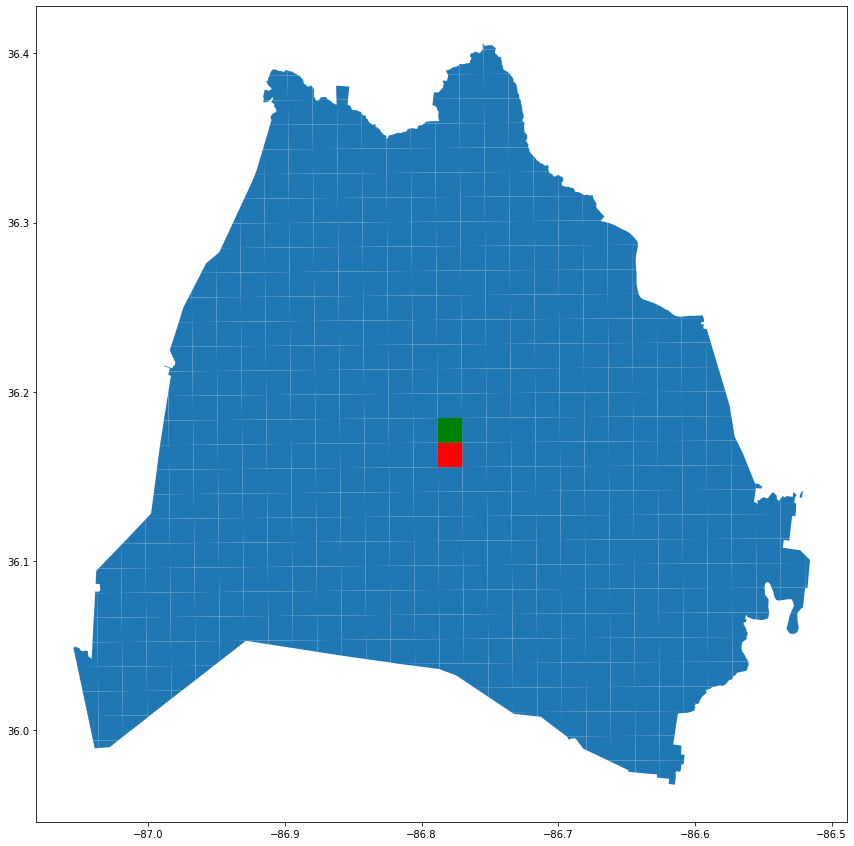

In [24]:
dav_grids3 = dav_grids2
dax = dav_grids3.plot(figsize=(15, 15))
dav_grids3[dav_grids3.grid_num == 299].plot(ax = dax, figsize=(15, 15), color='red')
dav_grids3[dav_grids3.grid_num == 300].plot(ax = dax, figsize=(20, 20), color='green')

In [25]:
joined3 = joined2
joined3.dropna(subset = ["time_local"], inplace=True)

In [26]:
incidents_mat = [np.arange(len(incidents_per_month))]

start_time = 1483250400000 # 2017-01-01 00:00:00
end_time = 1614671157253 # 2021-03-02 01:45:57.253000
duration = int(math.ceil((end_time - start_time)/1000))
for k in range(dav_grids2.grid_num.iloc[-1]+1):
    g_dav = joined3[joined3["grid_num"]==k]
#     print(g_dav["grid_num"])
    
    curr_time = start_time/1000
    incidents_per_month = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/2592000))]
    incidents_per_day = [0 for i in range(int(duration/86400))]
    incidents_per_4hrs = [0 for i in range(int(duration/14400)+10)]
    counter_4hrs = 0

    for i in range(g_dav.shape[0]):
        inc_time = (g_dav.time_local.iloc[i])/1000 #incident time #incidents.time_local
        while True:
            limit_time = curr_time +14400
    #         print(inc_time-limit_time, inc_time-curr_time)
            if (inc_time < limit_time):
                incidents_per_4hrs[counter_4hrs]+=1
#                 print("found")
                break

            else:
                curr_time = limit_time
                counter_4hrs += 1
                
    sum_day = incidents_per_4hrs[0]
    counter_day = 0
    for i in range(1, counter_4hrs+1): 
        if i%6 == 0:
            incidents_per_day[counter_day] = sum_day
            counter_day+=1
            sum_day = 0
        sum_day += incidents_per_4hrs[i]
#     print(k)
    if (k == 299):
        print(sum(incidents_per_day))
        
    sum_month = incidents_per_day[0]
    counter_month = 0
    for i in range(1, counter_day): 
        if i%30 == 0:
            incidents_per_month[counter_month] = sum_month
            counter_month+=1
            sum_month = 0
        sum_month += incidents_per_day[i]
#         print(sum_month)
        
    incidents_mat.append(incidents_per_month)

568


In [ ]:
# (incidents_mat[100])

In [27]:
df1 = pd.DataFrame()
# data = np.zeros((len(incidents_per_day), dav_grids2.grid_num.iloc[-1]+2))
df1 = pd.DataFrame(data = incidents_mat)
df1 = df1.transpose()
df1.columns = ["days"]+["grid"+str(i) for i in range(dav_grids2.grid_num.iloc[-1]+1)]

In [28]:
df2 = pd.DataFrame()
['80', '81', '82', '99', '101', '123', '124', '125']
# df2["target"] = incidents_mat[300]
# df2["n"] = incidents_mat[274]
# df2["nw"] = incidents_mat[275]
# df2["w"] = incidents_mat[276]
# df2["sw"] = incidents_mat[299]
# df2["s"] = incidents_mat[301]
# df2["se"] = incidents_mat[326]
# df2["e"] = incidents_mat[327]
# df2["ne"] = incidents_mat[328]
df2["target"] = incidents_mat[101]
df2["n"] = incidents_mat[81]
df2["nw"] = incidents_mat[82]
df2["w"] = incidents_mat[83]
df2["sw"] = incidents_mat[100]
df2["s"] = incidents_mat[102]
df2["se"] = incidents_mat[124]
df2["e"] = incidents_mat[125]
df2["ne"] = incidents_mat[126]
df = df2
df = df.reset_index()


In [29]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [30]:
np.random.rand(len(df))

array([0.51761681, 0.40651617, 0.6357385 , 0.24917415, 0.99211389,
       0.16544512, 0.27026515, 0.12795516, 0.4590578 , 0.30439805,
       0.51077242, 0.62665442, 0.65136561, 0.84912895, 0.74695721,
       0.12082212, 0.43162613, 0.32150167, 0.79752967, 0.69412906,
       0.33418592, 0.8135891 , 0.09408152, 0.91847309, 0.39699033,
       0.29623344, 0.76420883, 0.61722416, 0.49459734, 0.3948078 ,
       0.98140032, 0.0721812 , 0.90930494, 0.01551123, 0.32836803,
       0.14778873, 0.16589804, 0.17583154, 0.50614207, 0.76687134,
       0.83481359, 0.59833898, 0.98238621, 0.13216987, 0.34434611,
       0.08860836, 0.48900699, 0.56330144, 0.0109522 , 0.3423718 ])

In [31]:
df_train = df.query('index<=40')
df_test = df.query('index>40').reset_index().drop('index', axis=1)
# mask = np.random.rand(len(df)) < 0.8

# df_train = df[mask]
# df_test = df[~mask]
# print('Training data set length='+str(len(df_train)))
# print('Testing data set length='+str(len(df_test)))

In [32]:
expr = """target ~ target+ n + ne + e + se + s + sw + w + nw"""

In [33]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
y_test

,target
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0
5,0.0
6,0.0
7,0.0
8,0.0


In [34]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# u, s, vt = np.linalg.svd(poisson_training_results.exog, 0)
# print(s)

In [35]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                   41
Model:                            GLM   Df Residuals:                       32
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7.3069
Date:                Tue, 25 Jan 2022   Deviance:                   3.6742e-07
Time:                        11:58:41   Pearson chi2:                 1.84e-07
No. Iterations:                    23   Pseudo R-squ. (CS):             0.5061
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -36.3490    939.894     -0.039      0.9

In [36]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean       mean_se  mean_ci_lower  mean_ci_upper
0  2.819070e-14  2.314723e-11            0.0            inf
1  6.325764e-06  2.837533e-03            0.0            inf
2  8.357728e-16  7.259792e-13            0.0            inf
3  4.820433e-20  1.054660e-16            0.0            inf
4  1.771622e-08  2.208224e-05            0.0            inf
5  5.682142e-19  1.110267e-15            0.0            inf
6  2.102059e-18  2.252820e-15            0.0            inf
7  1.863861e-07  2.708954e-04            0.0            inf
8  2.880309e-11  1.636131e-08            0.0            inf


C:\Users\risha\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)


0    2.819070e-14
1    6.325764e-06
2    8.357728e-16
3    4.820433e-20
4    1.771622e-08
5    5.682142e-19
6    2.102059e-18
7    1.863861e-07
8    2.880309e-11
Name: mean, dtype: float64


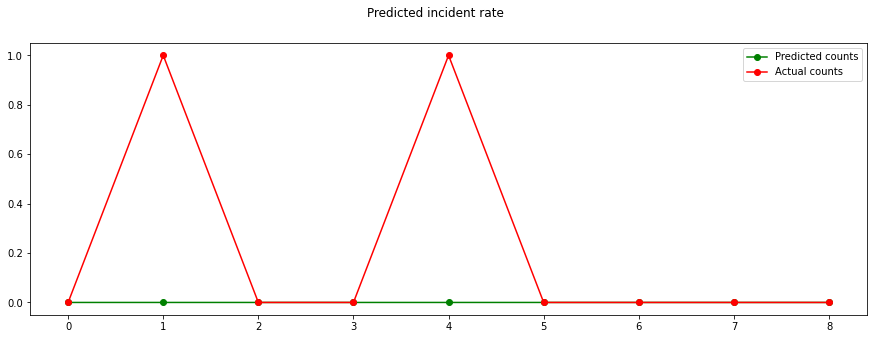

In [37]:
predicted_counts=predictions_summary_frame['mean']
print(predicted_counts)
actual_counts = y_test['target']
fig = plt.figure(figsize = (15, 5))
fig.suptitle('Predicted incident rate')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

In [38]:
gdf = dav_grids2.loc[:, ('grid_num', 'geometry')]
# gdf.grid_num = gdf.grid_num.astype(str)
gdf["neighbors"] = None  

for index, row in gdf.iterrows():  
#     print(index, row)
    neighbors = gdf[gdf.geometry.touches(row['geometry'])].grid_num.tolist() 
    gdf.at[index, "neighbors"] = (neighbors)
#         gdf.at[index, "neighbors"] = "".join(neighbors)

    
# gdf.grid_num = gdf.grid_num.astype(int)
# gdf.neighbors = gdf.neighbors.astype(int)


(50, 605)


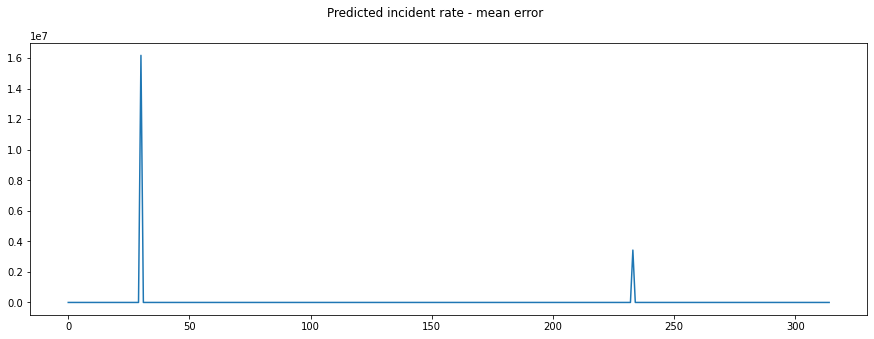

In [40]:
import time
from statistics import mean

df1 = pd.DataFrame()
# data = np.zeros((len(incidents_per_day), dav_grids2.grid_num.iloc[-1]+2))
df1 = pd.DataFrame(data = incidents_mat)
df1 = df1.transpose()
df1.columns = ["days"]+["grid"+str(i) for i in range(dav_grids2.grid_num.iloc[-1]+1)]
df2 = pd.DataFrame()
mean_error = []
print(df1.shape)
for i in range(0,gdf.shape[0]): #gdf.shape[0]
    if all(v == 0 for v in incidents_mat[int(gdf.grid_num.iloc[i])+1]):
        continue
#     print(i)
    expr = """target ~ target """
    df2["target"] = incidents_mat[int(gdf.grid_num.iloc[i])+1]
    nbors = gdf.iloc[i].neighbors
    for j in range(len(nbors)):
        nbor_name = "n"+str(j)
        df2[nbor_name] = incidents_mat[int(nbors[j])+1]
        expr = expr + """+ """+nbor_name+""" """
        
    df = df2
    df = df.reset_index()
    df_train = df.query('index<=40')
    df_test = df.query('index>40').reset_index().drop('index', axis=1)
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    try:
        poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    except:
        # print("caught", i)
        continue
    poisson_predictions = poisson_training_results.get_prediction(X_test)
    predictions_summary_frame = poisson_predictions.summary_frame()

    predicted_counts=predictions_summary_frame['mean']
    
    actual_counts = y_test['target']
    mean_error.append(mean(abs(x - y) for x, y in zip(actual_counts, predicted_counts)))

#     predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
#     actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
#     plt.legend(handles=[predicted, actual])
#     plt.show()
#     time.sleep(5)



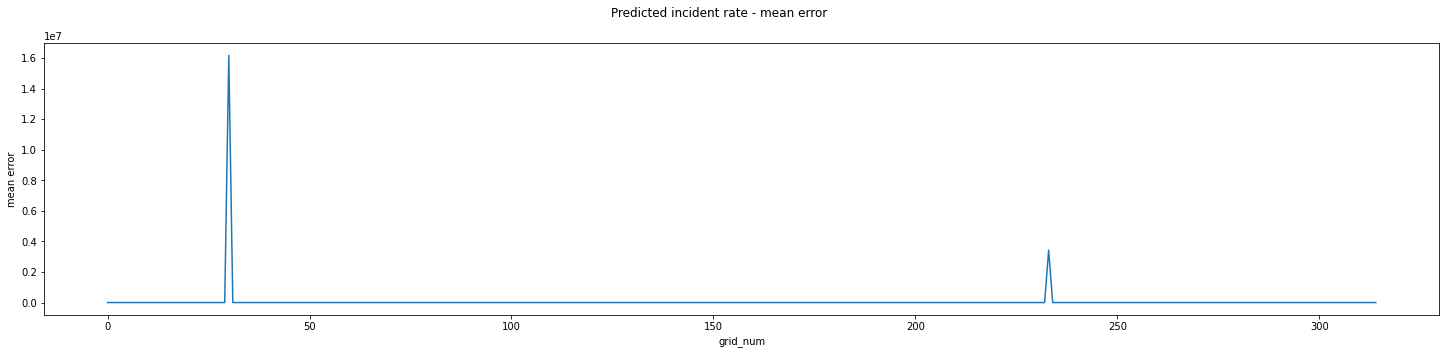

In [42]:
fig = plt.figure(figsize = (25, 5))
fig.suptitle('Predicted incident rate - mean error')
plt.plot(mean_error)
plt.xlabel("grid_num")
plt.ylabel("mean error")
plt.show()